In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import cm

%matplotlib inline

plt.rc("text", usetex=False)
plt.rc("font", family="sans-serif", size=12)

Reaction functions

In [2]:
def f(v, w, a, b, epsilon):
    return v * (v - a) * (1 - v) - w

def g(v, w, a, b, epsilon):
    return epsilon * (v - b * w)

Method of Lines Discretization of PDE

Code adapted from https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html#mol

In [3]:
def rdPDE(t, y, a, b, epsilon, D, dx):
    # The vectors v and w are interleaved in y for computational speed
    # every other entry is
    v = y[0::2]
    w = y[1::2]

    # dydt is the return value of this function.
    dydt = np.empty_like(y)

    dvdt = dydt[::2]
    dwdt = dydt[1::2]

    #v
    dvdt[0]    = f(v[0],    w[0],    a, b, epsilon) +  D * (-2.0*v[0] + 2.0*v[1]) / dx**2
    dvdt[1:-1] = f(v[1:-1], w[1:-1], a, b, epsilon) +  D * np.diff(v,2) / dx**2
    dvdt[-1]   = f(v[-1],   w[-1],   a, b, epsilon) +  D * (-2.0*v[-1] + 2.0*v[-2]) / dx**2

    #w
    dwdt[0]    = g(v[0],    w[0],    a, b, epsilon)
    dwdt[1:-1] = g(v[1:-1], w[1:-1], a, b, epsilon)
    dwdt[-1]   = g(v[-1],   w[-1],   a, b, epsilon)

    dydt[::2] = dvdt
    dydt[1::2] = dwdt

    return dydt

Set parameters, numerical parameters, and initial conditions

In [4]:
#numerical parameters
N = 1000
L = 1000
x = np.linspace(0, L, N)
dx = L/N

#model parameters
a = 0.1
b = 1e-4
epsilon = 0.005
D = 5

#initial conditions
v0 = np.zeros(np.size(x))
w0 = np.zeros(np.size(x))
v0[0:10] = 1

y0 = np.zeros(2*N)
y0[::2] = v0
y0[1::2] = w0

Solve ODE system, using lambda function to pass additional arguments (parameters), for time [0, 2000], initial condition y0, method is 'LSODA'. You could also use 'Radau' or 'BDF' since this system is stiff. lband and uband parameters are will only work for LSODA. They describe where the Jacobian is non-zero

In [5]:
%time
sol = solve_ivp(lambda t,y: rdPDE(t, y, a, b, epsilon, D, dx), 
                [0, 2000], y0, t_eval=np.linspace(0,2000,500),
                method='LSODA',lband=2,uband=2)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


Output

In [6]:
t = sol.t
y = sol.y

In [7]:
print(np.shape(t))
print(np.shape(x))
print(np.shape(y))

(500,)
(1000,)
(2000, 500)


In [8]:
v = y[0::2,:]
w = y[1::2,:]

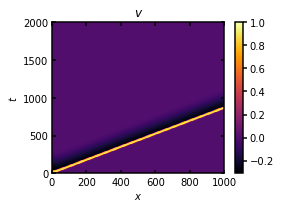

In [9]:
fig = plt.figure("fig1",figsize=(4,3))
ax1 = plt.subplot(111)
pmesh = plt.pcolormesh(x,t,v.T,cmap=cm.inferno)
cbar = fig.colorbar(pmesh,ax=ax1)
# plt.axhline(y=20,linestyle='--',linewidth=2,color='w')
cbar.outline.set_linewidth(1.5)
cbar.ax.tick_params(width=1.5)
ax1.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=10 , width=1.5)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$t$')
ax1.set_title(r'$v$')
ax1.spines["left"].set_linewidth(1.5)
ax1.spines["top"].set_linewidth(1.5)
ax1.spines["right"].set_linewidth(1.5)
ax1.spines["bottom"].set_linewidth(1.5)

plt.tight_layout()
plt.savefig('FHN_pulse.tif',dpi=600)


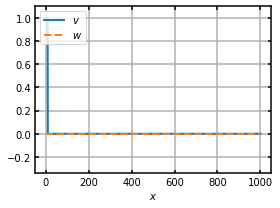

In [10]:
import matplotlib.animation as animation
fig = plt.figure(figsize=(4,3))
ax = plt.subplot(111)
ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=10 , width=1.5)
ax.set_xlabel(r'$x$')
# ax.set_ylabel('Activity')
ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
# ax.set_xlim(0,1)
ax.set_ylim(1.1*np.min([np.min(v),np.min(w)]),1.1*np.max([np.max(v),np.max(w)]))
ax.grid(linewidth=1.5)
# title = plt.title(r'$b$=%1.2f, $\delta$=%1.2f' %(b, delta))
line_v, = ax.plot(x,v[:,0],linewidth=2,label=r'$v$')
line_w, = ax.plot(x,w[:,0],'--',linewidth=2,label=r'$w$')
plt.legend(loc=2)
plt.tight_layout()

def animate(i):
    line_v.set_ydata(v[:,i])
    line_w.set_ydata(w[:,i])
    return line_v, line_w

ani = animation.FuncAnimation(fig,animate,frames=np.size(t))
ani.save("FHN_pulse.mp4",fps=30,dpi=300)